In [ ]:
#from google.colab import files
#files.upload()

### About Dataset

The data that is used in this project originally comes from the UCI machine learning repository. The data consists of over 100000 hospital admissions from patients with diabetes from 130 US hospitals between 1999–2008.It contains over 50 features with each instance representing patient and hospital outcomes (whether they were readmitted to the hospital).

In [ ]:
#Importing necessary libraries
import pandas as pd
import numpy as np

#data visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

#SMOTE package to address imbalanced classes
from imblearn.over_sampling import SMOTE

#machine learning packages (sklearn + xgboost)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from warnings import filterwarnings
filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Data Processing

In [ ]:
df=pd.read_csv("diabetic_data.csv",na_values='?')

In [ ]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
print("Number of samples:", len(df))

Number of samples: 101766


In [ ]:
#Let us explore readmitted column
df["readmitted"].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [ ]:
#readmitted column is our output variable. Hence encoding the column.
#We are predicting patient readmission within 30 days.Hence mapping it to 1 and rest all to 0.
df['readmitted'] = df.readmitted.map({'NO':0, '>30':0, '<30':1})

In [ ]:
df.readmitted.value_counts()

0    90409
1    11357
Name: readmitted, dtype: int64

From the value_counts of readmitted column, it is clear that we have only 11357 positive and 90409 negative values. Hence this is imbalanced classification. We will address this later.

## Missing Values

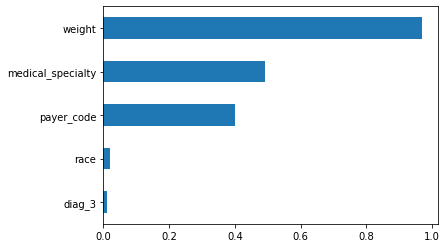

In [ ]:
missing=round((df.isna().sum()/len(df)),2).sort_values(ascending=True)
missing = missing[missing > 0]
missing.plot(kind='barh')

In [ ]:
missing

diag_3               0.01
race                 0.02
payer_code           0.40
medical_specialty    0.49
weight               0.97
dtype: float64

The top three features with missing values are weight, medical_specialty, and prayer_code. We will address missing values by either droping or imputing.

In [ ]:
#Let us explore discharge_disposition_id
#This column tell us where the patient went after the hospitalization 
#From IDs_mapping.csv provided by UCI we can see that 11,13,14,19,20,21 are
#related to death or hospice. Hence we should remove these samples from the predictive model as they cannot be readmitted.

df=df.loc[~df["discharge_disposition_id"].isin([11,13,14,19,20,21])]

In [ ]:
# drop duplicate patient encounters
df.drop_duplicates('patient_nbr', keep = 'first')
df.drop('patient_nbr', axis = 1, inplace = True)

## Feature Engineering 

In [ ]:
df.dtypes#exploring the datatypes

encounter_id                 int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide       

In [ ]:
#Storing numerical columns and categorical columns into two differents list.
num_cols=[]
cat_cols=[]
for i in df.columns:
  if df[i].dtypes=="int64":
    num_cols.append(i)
  else :
    cat_cols.append(i)


In [ ]:
#Lets us see the numerical and categorical columns
num_cols,cat_cols

(['encounter_id',
  'admission_type_id',
  'discharge_disposition_id',
  'admission_source_id',
  'time_in_hospital',
  'num_lab_procedures',
  'num_procedures',
  'num_medications',
  'number_outpatient',
  'number_emergency',
  'number_inpatient',
  'number_diagnoses',
  'readmitted'],
 ['race',
  'gender',
  'age',
  'weight',
  'payer_code',
  'medical_specialty',
  'diag_1',
  'diag_2',
  'diag_3',
  'max_glu_serum',
  'A1Cresult',
  'metformin',
  'repaglinide',
  'nateglinide',
  'chlorpropamide',
  'glimepiride',
  'acetohexamide',
  'glipizide',
  'glyburide',
  'tolbutamide',
  'pioglitazone',
  'rosiglitazone',
  'acarbose',
  'miglitol',
  'troglitazone',
  'tolazamide',
  'examide',
  'citoglipton',
  'insulin',
  'glyburide-metformin',
  'glipizide-metformin',
  'glimepiride-pioglitazone',
  'metformin-rosiglitazone',
  'metformin-pioglitazone',
  'change',
  'diabetesMed'])

Exploring Numerical cols

In [ ]:
df[num_cols].isnull().sum()#we don't have any null values in numerical cols.

encounter_id                0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
number_diagnoses            0
readmitted                  0
dtype: int64

In [ ]:
for i in num_cols:
  print("The shape of {} is {}".format(i,len(df[i].value_counts())))
  print("___________________________________________")

The shape of encounter_id is 99343
___________________________________________
The shape of admission_type_id is 8
___________________________________________
The shape of discharge_disposition_id is 21
___________________________________________
The shape of admission_source_id is 17
___________________________________________
The shape of time_in_hospital is 14
___________________________________________
The shape of num_lab_procedures is 118
___________________________________________
The shape of num_procedures is 7
___________________________________________
The shape of num_medications is 75
___________________________________________
The shape of number_outpatient is 39
___________________________________________
The shape of number_emergency is 33
___________________________________________
The shape of number_inpatient is 21
___________________________________________
The shape of number_diagnoses is 16
___________________________________________
The shape of readmitted is 2
_

In [ ]:
df.drop("encounter_id", inplace=True, axis=1)# This is an just identifier and not useful variable   

In [ ]:
id=pd.read_csv("IDs_mapping.csv")

In [ ]:
id.head(70)

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
...,...,...
62,22,Transfer from hospital inpt/same fac reslt in...
63,23,Born inside this hospital
64,24,Born outside this hospital
65,25,Transfer from Ambulatory Surgery Center


In [ ]:
#'admission_type_id','discharge_disposition_id','admission_source_id' are numerical , but are IDs.
#They should be considered categorical.
df[['admission_type_id','discharge_disposition_id','admission_source_id']]=df[['admission_type_id','discharge_disposition_id','admission_source_id']].astype("str")
df["readmitted"]=df["readmitted"].astype("str")

Exploring Categorical columns

In [ ]:
df[cat_cols].isnull().sum()

race                         2234
gender                          0
age                             0
weight                      96218
payer_code                  39398
medical_specialty           48616
diag_1                         20
diag_2                        356
diag_3                       1419
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
examide                         0
citoglipton                     0
insulin                         0
glyburide-metf

In [ ]:
for i in cat_cols:
  print("The shape of {} is {}".format(i,len(df[i].value_counts())))
  print("___________________________________________")

The shape of race is 5
___________________________________________
The shape of gender is 3
___________________________________________
The shape of age is 10
___________________________________________
The shape of weight is 9
___________________________________________
The shape of payer_code is 17
___________________________________________
The shape of medical_specialty is 72
___________________________________________
The shape of diag_1 is 715
___________________________________________
The shape of diag_2 is 747
___________________________________________
The shape of diag_3 is 786
___________________________________________
The shape of max_glu_serum is 4
___________________________________________
The shape of A1Cresult is 4
___________________________________________
The shape of metformin is 4
___________________________________________
The shape of repaglinide is 4
___________________________________________
The shape of nateglinide is 4
____________________________________

In [ ]:
#payer_code and medical_speciality have many categorical variables. we will consider them when making features.
#diag1, diag2, diag3 have lot of values.Hence we will drop them out. 
df.drop(["diag_1", "diag_2","diag_3"], inplace=True,axis=1)

In [ ]:
#Weight has too many null values.Hence dropping weight column
df.drop(["weight"], inplace=True,axis=1)

In [ ]:
#race, payer_code and medical_specialty have null values. We will fill these null values with "UNK" as these are categorical columns.
df["race"]=df["race"].fillna("UNK")
df["payer_code"]=df["payer_code"].fillna("UNK")
df["medical_specialty"]=df["medical_specialty"].fillna("UNK")

In [ ]:
#Let us explore Medical_specialty.
df["medical_specialty"].value_counts().head(15)

UNK                                48616
InternalMedicine                   14237
Emergency/Trauma                    7419
Family/GeneralPractice              7252
Cardiology                          5279
Surgery-General                     3059
Nephrology                          1539
Orthopedics                         1392
Orthopedics-Reconstructive          1230
Radiologist                         1121
Pulmonology                          854
Psychiatry                           853
Urology                              682
ObstetricsandGynecology              669
Surgery-Cardiovascular/Thoracic      642
Name: medical_specialty, dtype: int64

In [ ]:
#We can see that most of them unknown and count decreases drastically for other categories.
#We will create a new variable that has 11 options(the top 10 specialities and then an "other category") we are bucketing the values here.

top10=df["medical_specialty"].value_counts().head(10).index

df["new_med_spec"]=df["medical_specialty"].copy
#dropping out medical specialty column 
df.drop(["medical_specialty"], inplace=True,axis=1)

In [ ]:
df.loc[~df.new_med_spec.isin(top10),"new_med_spec"]="Other"

In [ ]:
#Let us explore age column
df.age.value_counts().index

Int64Index([80, 70, 60, 50, 40, 30, 90, 20, 10, 0], dtype='int64')

In [ ]:
#Mapping 0 to 90 by 10's as we need numerical data.
num_age={'[70-80)':80, '[60-70)':70, '[50-60)':60, '[80-90)':50, '[40-50)':40, '[30-40)':30,
       '[90-100)':90, '[20-30)':20, '[10-20)':10, '[0-10)':0}
df["age"]=df.age.map(num_age)

In [ ]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,new_med_spec
0,Caucasian,Female,NaN,6,25,1,1,UNK,41,0,1,0,0,0,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,Other
1,Caucasian,Female,NaN,1,1,7,3,UNK,59,0,18,0,0,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,Other
2,AfricanAmerican,Female,NaN,1,1,7,2,UNK,11,5,13,2,0,1,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,Other
3,Caucasian,Male,NaN,1,1,7,2,UNK,44,1,16,0,0,0,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,Other
4,Caucasian,Male,NaN,1,1,7,1,UNK,51,0,8,0,0,0,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,Other


In [ ]:
#Let us explore data types again now
#We will one hot encode the categorical columns.

In [ ]:
new_num_cols=[]
new_cat_cols=[]
for i in df.columns:
  if df[i].dtypes=="int64":
    new_num_cols.append(i)
  else :
    new_cat_cols.append(i)

In [ ]:
new_cat_cols

['race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'payer_code',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted',
 'new_med_spec']

In [ ]:
for i in new_cat_cols:
  print("The shape of {} is {}".format(i,len(df[i].value_counts())))
  print("___________________________________________")

The shape of race is 6
___________________________________________
The shape of gender is 3
___________________________________________
The shape of age is 0
___________________________________________
The shape of admission_type_id is 8
___________________________________________
The shape of discharge_disposition_id is 21
___________________________________________
The shape of admission_source_id is 17
___________________________________________
The shape of payer_code is 18
___________________________________________
The shape of max_glu_serum is 4
___________________________________________
The shape of A1Cresult is 4
___________________________________________
The shape of metformin is 4
___________________________________________
The shape of repaglinide is 4
___________________________________________
The shape of nateglinide is 4
___________________________________________
The shape of chlorpropamide is 4
___________________________________________
The shape of glimepiride is 

In [ ]:
new_cat_cols.pop(-2)#popping out our output variable "readmitted" to one hot encode all other categorical variables.

'readmitted'

In [ ]:
#One hot encoding the categorical columns other than readmitted.
df_cat=pd.get_dummies(df[new_cat_cols], drop_first=True)

In [ ]:
df=pd.concat([df,df_cat], axis=1)

In [ ]:
df.drop(new_cat_cols,axis=1, inplace=True)

In [ ]:
df.shape

(99343, 132)

Building Training and Test samples

In [ ]:
X=df.drop("readmitted",axis=1)
y=df["readmitted"]

In [ ]:
#Normalizing the data through StandardScaler

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_scaled=pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

Addressing Imbalanced Dataset.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, stratify = y, random_state = 42)

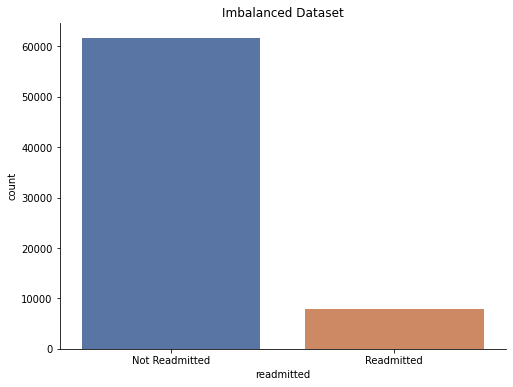

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(y_train, palette='deep')
sns.despine()
plt.title('Imbalanced Dataset')
plt.xticks([0,1],['Not Readmitted', 'Readmitted'])
plt.show()

In [ ]:
#Remedy to imbalanced Dataset is to upsample the minority class in our training dataset through SMOTE(Synthetic Minority Oversampling Technique(SMOTE))

from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

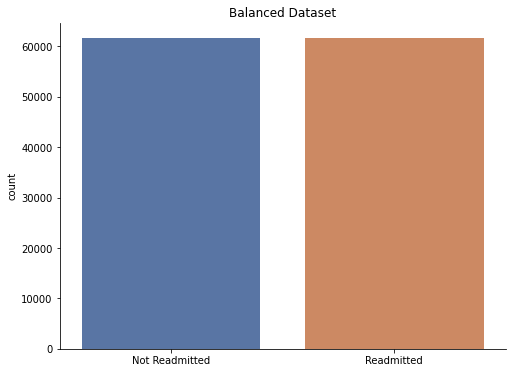

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(y_train_res, palette='deep')
sns.despine()
plt.title('Balanced Dataset')
plt.xticks([0,1],['Not Readmitted', 'Readmitted'])
plt.show()

Base Machine Learning Algorithms

In [ ]:
# Plot Confusion Matrix
def plot_cm(estimator,title):
    '''Plots confusion matrix
    
    Plots confusion matrix
    
    Args:
        model: 
            Trained (fitted) ML algorithm
        title:
            Machine algorithm that corresponds with the estimator to insert into title of plot
    Returns: 
        Plot of confusion matrix for unseen test data set
        
    '''        
    
    from sklearn.metrics import plot_confusion_matrix
    
    plt.figure(figsize=(10,8))
    plot_confusion_matrix(estimator, X=X_test, y_true=y_test, 
                          display_labels=['Not Readmitted', 'Readmitted'], 
                          cmap='Blues', values_format='d')
    plt.title(str(title)+' '+'Confusion Matrix')

In [ ]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train_res, y_train_res)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

<Figure size 720x576 with 0 Axes>

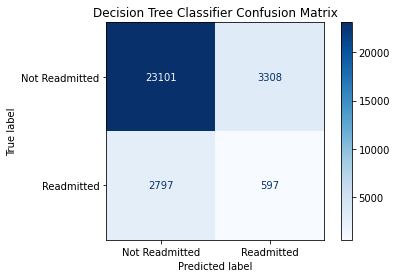

In [ ]:
plot_cm(dt_clf, "Decision Tree Classifier")

In [ ]:
logmodel = LogisticRegression()
logmodel.fit(X_train_res, y_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<Figure size 720x576 with 0 Axes>

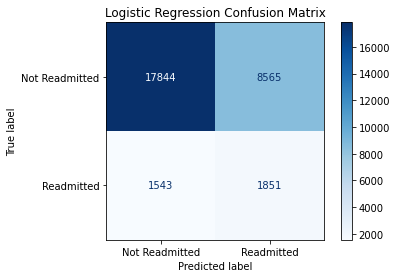

In [ ]:
plot_cm(logmodel, 'Logistic Regression')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_jobs = -1)

rf_clf.fit(X_train_res, y_train_res)
rf_preds = rf_clf.predict(X_test)

<Figure size 720x576 with 0 Axes>

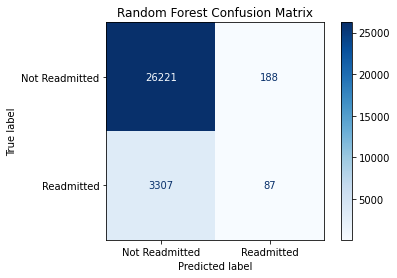

In [ ]:
plot_cm(rf_clf, 'Random Forest')

Decision Tree Hyperparameter Tuning

In [ ]:
max_depth = list(range(1,15,2))
max_features = list(range(1,9))
min_samples_leaf = list(range(2,10,2))
criterion = ['gini', 'entropy']


params_dt = {'max_depth':max_depth, 
            'max_features':max_features, 
            'min_samples_leaf':min_samples_leaf,
            'criterion':criterion}

dt = DecisionTreeClassifier()

dt_cv = GridSearchCV(dt, params_dt, cv=5, verbose=1, n_jobs=-1)

dt_cv.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 448 candidates, totalling 2240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 2240 out of 2240 | elapsed: 11.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [ ]:
dt_cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=13, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

<Figure size 720x576 with 0 Axes>

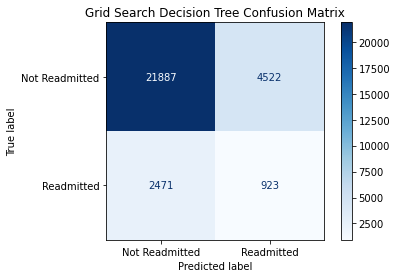

In [ ]:
plot_cm(dt_cv.best_estimator_, "Grid Search Decision Tree")


Logistic Regression Hyperparameter Tuning

In [ ]:
penalty = ['l1', 'l2']
C = np.logspace(0,4,10)

params_lr = {'penalty':penalty, 'C':C}

lr = LogisticRegression()

lr_cv = GridSearchCV(lr, param_grid=params_lr, cv=5, verbose=1, n_jobs=-1, scoring='roc_auc')

lr_cv.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             s

In [ ]:
lr_cv.best_estimator_

LogisticRegression(C=2.7825594022071245, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<Figure size 720x576 with 0 Axes>

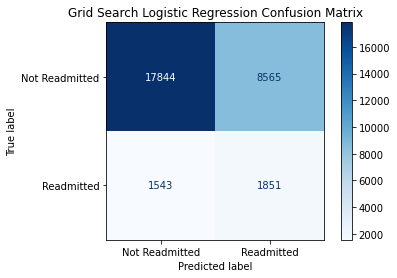

In [ ]:
plot_cm(lr_cv, "Grid Search Logistic Regression")

Logistic Regression Bagging

In [ ]:
lr_bagger = BaggingClassifier(lr_cv.best_estimator_, n_jobs=-1)
lr_bagger.fit(X_train_res, y_train_res)

BaggingClassifier(base_estimator=LogisticRegression(C=2.7825594022071245,
                                                    class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='lbfgs', tol=0.0001,
                                                    verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10,

<Figure size 720x576 with 0 Axes>

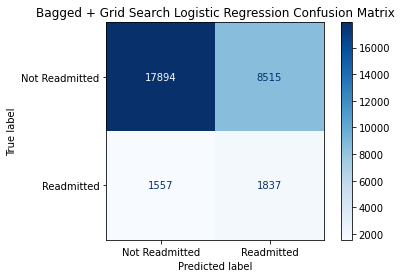

In [ ]:
plot_cm(lr_bagger, "Bagged + Grid Search Logistic Regression")